# Module load

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# For insert image
from IPython.display import Image

# Data load

In [2]:
def load_data(path):
    data_nc = xr.open_dataset(path)
    # save all the variables in data_nc file as a list.
    var_list = list(data_nc.data_vars.keys())
    
    #if the index of a variable of interest is not 0, 
    #you could edit the index number from 0 to other number in the very below line.
    var = var_list[1]
    data = data_nc.data_vars[var]
    print("completely load data with variable \"{0}\"".format(var))
    return data

In [3]:
path = 'sst.mnmean.nc'
data = load_data(path)
data

completely load data with variable "sst"


<xarray.DataArray 'sst' (time: 2017, lat: 89, lon: 180)>
[32312340 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

# Transform longitude and latitude
Transform longitude into -180 ~ 180.  
Sort longitude and latitude in ascending order

In [4]:
def sort_latlon(data):
    data_ = data.assign_coords({"lon" : (((data.lon + 180) % 360) - 180)})
    data_ = data_.sortby('lon')
    data_ = data_.sortby('lat')
    return data_

In [5]:
# transform longitude
data = sort_latlon(data)
data

<xarray.DataArray 'sst' (time: 2017, lat: 89, lon: 180)>
[32312340 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

# Select nino3.4 region and calculate ONI (The Oceanic Niño Index)

 Sea surface temperatures are monitored in four “Niño” regions extending from the west coast of South America across the equatorial Pacific. These regions were created in the 1980s, but since then have been modified.  Regions 1 and 2 were combined to form the Niño 1+2 region. An overlap of regions 3 and 4 was found to have a good correlation with the SOI, and this region is called Niño 3.4.
(from : https://mrcc.purdue.edu/mw_climate/elNino/whatIsElNino.jsp)  

**Niño 1+2 (0-10S, 90W-80W)**:  The Niño 1+2 region is the smallest and eastern-most of the Niño SST regions, and corresponds with the region of coastal South America where El Niño was first recognized by the local populations.  This index tends to have the largest variance of the Niño SST indices.  

**Niño 3 (5N-5S, 150W-90W)**:  This region was once the primary focus for monitoring and predicting El Niño, but researchers later learned that the key region for coupled ocean-atmosphere interactions for ENSO lies further west (Trenberth, 1997).  Hence, the Niño 3.4 and ONI became favored for defining El Niño and La Niña events.  

**Niño 3.4 (5N-5S, 170W-120W)**:  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.  

**ONI (5N-5S, 170W-120W)**: The ONI uses the same region as the Niño 3.4 index.  The ONI uses a 3-month running mean, and to be classified as a full-fledged El Niño or La Niña, the anomalies must exceed +0.5C or -0.5C for at least five consecutive months.  This is the operational definition used by NOAA.  

**Niño 4 (5N-5S, 160E-150W)**: The  Niño 4 index captures SST anomalies in the central equatorial Pacific.  This region tends to have less variance than the other Niño regions.  
(from : https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

![nino](./nino-regions.png)
(image from : https://www.ncei.noaa.gov/access/monitoring/enso/sst)

In [6]:
# Calculate climatlogy
clim = data.sel(time=slice('1981-01-01','2010-01-01'),lon=slice(-170,-120), lat=slice(-5,5)).mean(dim=['time','lon','lat'])

# Calculate nino34
nino34 = data.sel(time=slice('1981-01-01', '2022-01-01'),lon=slice(-170,-120), lat=slice(-5,5)).mean(dim=['lon','lat'])

Oni index is 3-month moving averages of SST anomalies.

**Anomaly**  
: The difference between the average climate over a period of several decades or more, and the climate during a particular month or season.

In [7]:
# Calculate 3-month moving average 
nino34_rol3 = nino34.rolling(time=3, center = False).mean()

# Calculate anomalies
oni = nino34_rol3 - clim

# Plot ONI graph

Text(0.5, 1.0, 'ENSO ONI Values (Nino 3.4 Region)')

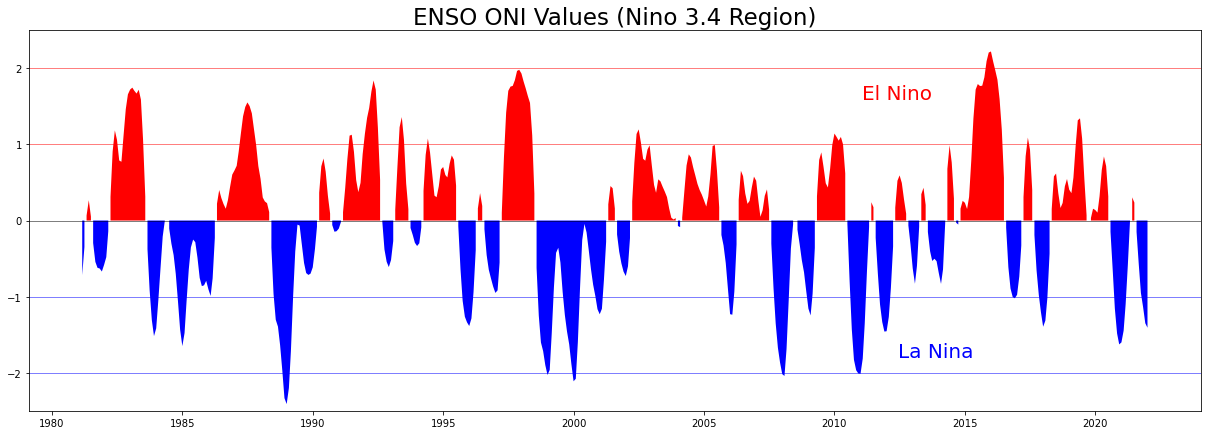

In [8]:
fig, ax = plt.subplots(1,1,figsize=(21, 7))

#Plot horizontal line
plt.axhline(1, color = 'red', linewidth = 1, alpha = 0.5)
plt.axhline(2, color = 'red', linewidth = 1, alpha = 0.5)
plt.axhline(-1, color = 'blue', linewidth = 1, alpha = 0.5)
plt.axhline(-2, color = 'blue', linewidth = 1, alpha = 0.5)

plt.axhline(color='k', linewidth=0.5)

#If data is greater than 0, the area below the line will be filled with red.
#If data is smaller than 0, the area below the line will be filled with blue.
plt.fill_between(nino34.time,oni, where = oni > 0, facecolor='red')
plt.fill_between(nino34.time,oni, where = oni < 0, facecolor='b')

ax.set_ylim([-2.5,2.5])

#Add text in the figure.
plt.text(15000, 1.6, 'El Nino', fontsize=20, color = 'red')
plt.text(15500, -1.8, 'La Nina', fontsize=20, color = 'b')

#Title
plt.title('ENSO ONI Values (Nino 3.4 Region)', fontsize = 23)

